In [25]:
root_dir = "../../Downloads/GENOME540/"
f_path = "Pyrococcus_horikoshii.fasta"
fasta_path = root_dir + f_path + ".txt"

In [26]:
def read_fasta(filename):
    with open(filename, 'r') as f:
        lines = f.read().splitlines()
        return lines[0], lines[1]

title, fasta = read_fasta(fasta_path)

In [27]:
import numpy as np

tokenize = lambda seq: np.array([{'A': 0, 'T': 1, 'G': 2, 'C': 3}[base] for base in seq])
V = tokenize(fasta)

In [28]:
# OLD VERSION
# low probabilities --> underflow
class HMM(object):

    def __init__(self, a, b, pi):
        self.A = a
        self.B = b
        self.pi = pi
        self.history = []
        self.iterations = 0

    def forward(self, V):
        alpha = np.zeros((V.shape[0], self.A.shape[0]))
        alpha[0, :] = self.pi * self.B[:, V[0]]
    
        for t in range(1, V.shape[0]):
            for j in range(self.A.shape[0]):
                alpha[t, j] = alpha[t - 1].dot(self.A[:, j]) * self.B[j, V[t]]
    
        return alpha

    def backward(self, V):
        beta = np.zeros((V.shape[0], self.A.shape[0]))
        beta[V.shape[0] - 1] = np.ones((self.A.shape[0]))
    
        for t in range(V.shape[0] - 2, -1, -1):
            for j in range(self.A.shape[0]):
                beta[t, j] = (beta[t + 1] * self.B[:, V[t + 1]]).dot(self.A[j, :])
    
        return beta

    def baum_welch(self, V, tolerance=0.1):

        prev_log_likelihood = -np.inf
        iteration = 1
        while True:

            # E-step: Compute the forward and backward probabilities
            alpha = self.forward(V)
            beta = self.backward(V)

            # M-step: Update the parameters
            gamma = alpha * beta / np.sum(alpha[-1])

            xi = np.zeros((V.shape[0] - 1, self.A.shape[0], self.A.shape[0]))
            for t in range(V.shape[0] - 1):
                xi[t] = alpha[t].reshape((-1, 1)) * self.A * self.B[:, V[t+1]].reshape((1, -1)) * beta[t+1] / np.sum(alpha[-1])

            A = np.sum(xi, axis=0) / np.sum(gamma[:-1], axis=0).reshape((-1, 1))
            B = np.zeros((self.B.shape[0], self.B.shape[1]))
            for k in range(self.B.shape[1]):
                B[:, k] = np.sum(gamma[V == k], axis=0) / np.sum(gamma, axis=0)
            pi = gamma[0]

            new_log_likelihood = np.sum(np.log(np.sum(alpha[-1])))

            print(f"Iteration {iteration}: {new_log_likelihood}")
            self.history.append(new_log_likelihood)

            if abs(new_log_likelihood - prev_log_likelihood) < tolerance:
                self.iterations = iteration
                break
            else:
                prev_log_likelihood = new_log_likelihood
                self.A, self.B, self.pi = A, B, pi

            iteration += 1

a = np.array([[0.999, 0.001], [0.01, 0.99]]) # transition probabilities
b = np.array([[0.3, 0.3, 0.2, 0.2], [0.15, 0.15, 0.35, 0.35]]) # emission probabilities
pi = np.array([0.996, 0.004]) # initiation probabilities

hmm = HMM(a, b, pi)
hmm.baum_welch(V[:500])

Iteration 1: -691.155015255711
Iteration 2: -672.3933543902132
Iteration 3: -672.3737466927938


In [5]:
from scipy.special import logsumexp

# NEW VERSION
# log probabilities --> no underflow
class HMM(object):

    def __init__(self, a, b, pi):
        self.A = a
        self.B = b
        self.pi = pi
        self.history = []
        self.iterations = 0

    def log_forward(self, V):
        log_alpha = np.zeros((V.shape[0], self.A.shape[0]))
        log_alpha[0, :] = np.log(self.pi) + np.log(self.B[:, V[0]])

        for t in range(1, V.shape[0]):
            for j in range(self.A.shape[0]):
                log_alpha[t, j] = logsumexp(log_alpha[t - 1] + np.log(self.A[:, j])) + np.log(self.B[j, V[t]])

        return log_alpha

    def log_backward(self, V):
        log_beta = np.zeros((V.shape[0], self.A.shape[0]))
        log_beta[V.shape[0] - 1] = np.log(1)

        for t in range(V.shape[0] - 2, -1, -1):
            for j in range(self.A.shape[0]):
                log_beta[t, j] = logsumexp(np.log(self.B[:, V[t + 1]]) + np.log(self.A[j, :]) + log_beta[t + 1])

        return log_beta

    def baum_welch(self, V, tolerance=0.1):

        prev_log_likelihood = -np.inf
        iteration = 1
        while True:

            # E-step: Compute the forward and backward probabilities
            log_alpha = self.log_forward(V)
            log_beta = self.log_backward(V)

            # M-step: Update the parameters
            log_gamma = log_alpha + log_beta - logsumexp(log_alpha[-1])

            log_xi = np.zeros((V.shape[0] - 1, self.A.shape[0], self.A.shape[0]))
            for t in range(V.shape[0] - 1):
                log_xi[t] = log_alpha[t].reshape((-1, 1)) + np.log(self.A) + np.log(self.B[:, V[t+1]].reshape((1, -1))) + log_beta[t+1] - logsumexp(log_alpha[-1])

            A = np.exp(logsumexp(log_xi, axis=0) - logsumexp(log_gamma[:-1], axis=0).reshape((-1, 1)))
            B = np.zeros((self.B.shape[0], self.B.shape[1]))
            for k in range(self.B.shape[1]):
                B[:, k] = np.exp(logsumexp(log_gamma[V == k], axis=0) - logsumexp(log_gamma, axis=0))
            pi = np.exp(log_gamma[0])

            new_log_likelihood = logsumexp(log_alpha[-1])

            print(f"Iteration {iteration+1}: {new_log_likelihood}")
            self.history.append(new_log_likelihood)

            if abs(new_log_likelihood - prev_log_likelihood) < tolerance:
                self.iterations = iteration
                break
            else:
                prev_log_likelihood = new_log_likelihood
                self.A, self.B, self.pi = A, B, pi

            iteration += 1

a = np.array([[0.999, 0.001], [0.01, 0.99]]) # transition probabilities
b = np.array([[0.3, 0.3, 0.2, 0.2], [0.15, 0.15, 0.35, 0.35]]) # emission probabilities
pi = np.array([0.996, 0.004]) # initiation probabilities

hmm = HMM(a, b, pi)
hmm.baum_welch(V)

Iteration 1: -2388054.8222540813
Iteration 2: -2386227.764153481
Iteration 3: -2386128.7508384692
Iteration 4: -2386067.889953988
Iteration 5: -2386023.013884547
Iteration 6: -2385935.23611618
Iteration 7: -2385507.1782518956
Iteration 8: -2382675.266307755
Iteration 9: -2375526.6993401097
Iteration 10: -2370106.92462016
Iteration 11: -2367993.605630379
Iteration 12: -2367268.789553345
Iteration 13: -2367000.982117434
Iteration 14: -2366888.749313139
Iteration 15: -2366832.241659154
Iteration 16: -2366796.5387797644
Iteration 17: -2366768.9630848444
Iteration 18: -2366744.741343427
Iteration 19: -2366721.9924126994
Iteration 20: -2366699.9211875536
Iteration 21: -2366678.1594567103
Iteration 22: -2366656.510509999
Iteration 23: -2366634.8513789163
Iteration 24: -2366613.09445259
Iteration 25: -2366591.169129087
Iteration 26: -2366569.0156222624
Iteration 27: -2366546.581177299
Iteration 28: -2366523.8170863874
Iteration 29: -2366500.6783681577
Iteration 30: -2366477.123347276
Iteration

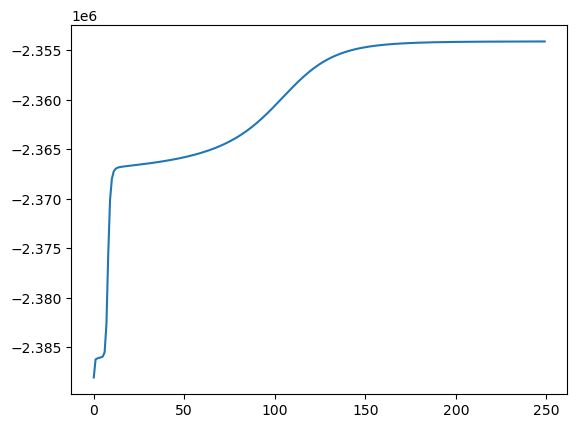

In [6]:
import matplotlib.pyplot as plt
plt.plot(hmm.history)

In [ ]:
print("Fasta:", f_path)
print(title)

print("\nIterations for Convergence:")
print(hmm.iterations)

print("\nLog Likelihood:")
print(hmm.history[-1])

print("\nInitial State Probabilities:")
print(hmm.pi)

print("\nTransition Probabilities:")
print(hmm.A)

print("\nEmission Probabilities:")
print(hmm.B)